In [1]:
%matplotlib inline

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import imread, imresize
import pandas as pd
import glob
import pickle
import keras.backend as K

from stn.conv_model import conv_model
from stn.conv_model import conv_model_no_color_adjust
from sklearn.utils import resample
from lib.utils import load_gtsrb
from keras.metrics import sparse_categorical_accuracy
from keras.utils import to_categorical

from parameters import *

Using TensorFlow backend.


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
signnames = pd.read_csv(DATA_DIR + 'signnames.csv')
X_train, y_train, X_val, y_val, X_test, y_test = load_gtsrb()

--- 
Load and test the model from GTSRB_Keras_STN   
https://github.com/hello2all/GTSRB_Keras_STN

In [3]:
model = conv_model()
model.load_weights("./keras_weights/stn.hdf5")

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 32, 32, 3)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 10)        40        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 10)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 10)        40        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 3)         33        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 3)         0         
__________

In [77]:
print(model.evaluate(X_train, to_categorical(y_train, NUM_LABELS)))
print(model.evaluate(X_test, to_categorical(y_test, NUM_LABELS)))
print(model.evaluate(X_val, to_categorical(y_val, NUM_LABELS)))

34799/34799 [==============================] - 16s 448us/step
[0.11535519357684933, 1.0]
12630/12630 [==============================] - 6s 450us/step
[0.1715500675442666, 0.9912905779605995]
4410/4410 [==============================] - 2s 462us/step
[0.13746237347996423, 0.9952380952380953]


In [70]:
get_stn_output = K.function([model.layers[0].input, K.learning_phase()],
                            [model.layers[5].output])

In [ ]:
get_stn_output = K.function([model.layers[8].input, K.learning_phase()],
                            [model.layers[8].output])

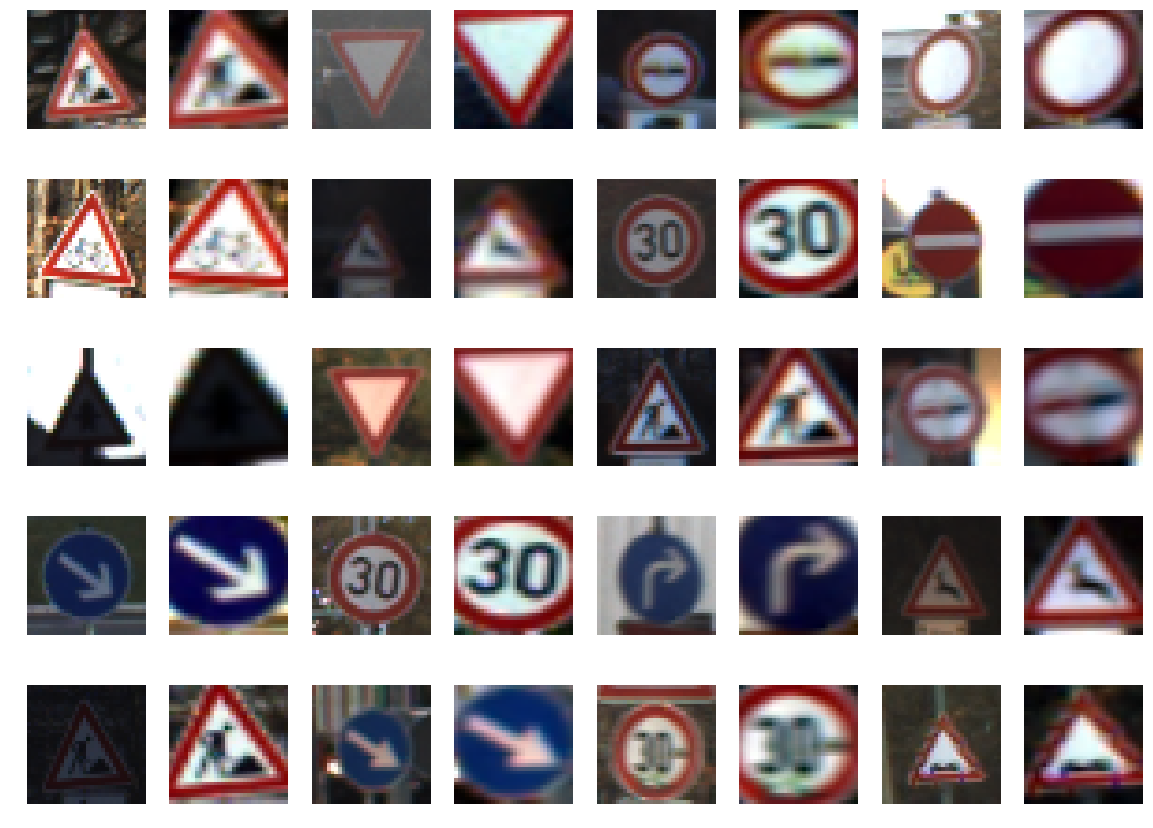

In [74]:
X = X_test
n = 20

f, ax = plt.subplots(int(np.ceil(n/4)), 8, figsize=(20, 15))
for i in range(n):
    
    ii = i//4
    jj = (i % 4)*2
    
    x = X[np.random.randint(len(X))]
    ax[ii, jj].imshow(x)
    ax[ii, jj].axis("off")
    
    stn_output = get_stn_output([x[np.newaxis, :], 0])[0]
    x = np.copy(stn_output[0])
    # x = (x - x.min())/(x.max() - x.min())
    for c in range(3):
        x_c = x[:, :, c]
        x[:, :, c] = (x_c - x_c.min())/(x_c.max() - x_c.min())
    ax[ii, jj + 1].imshow(x)
    ax[ii, jj + 1].axis("off")

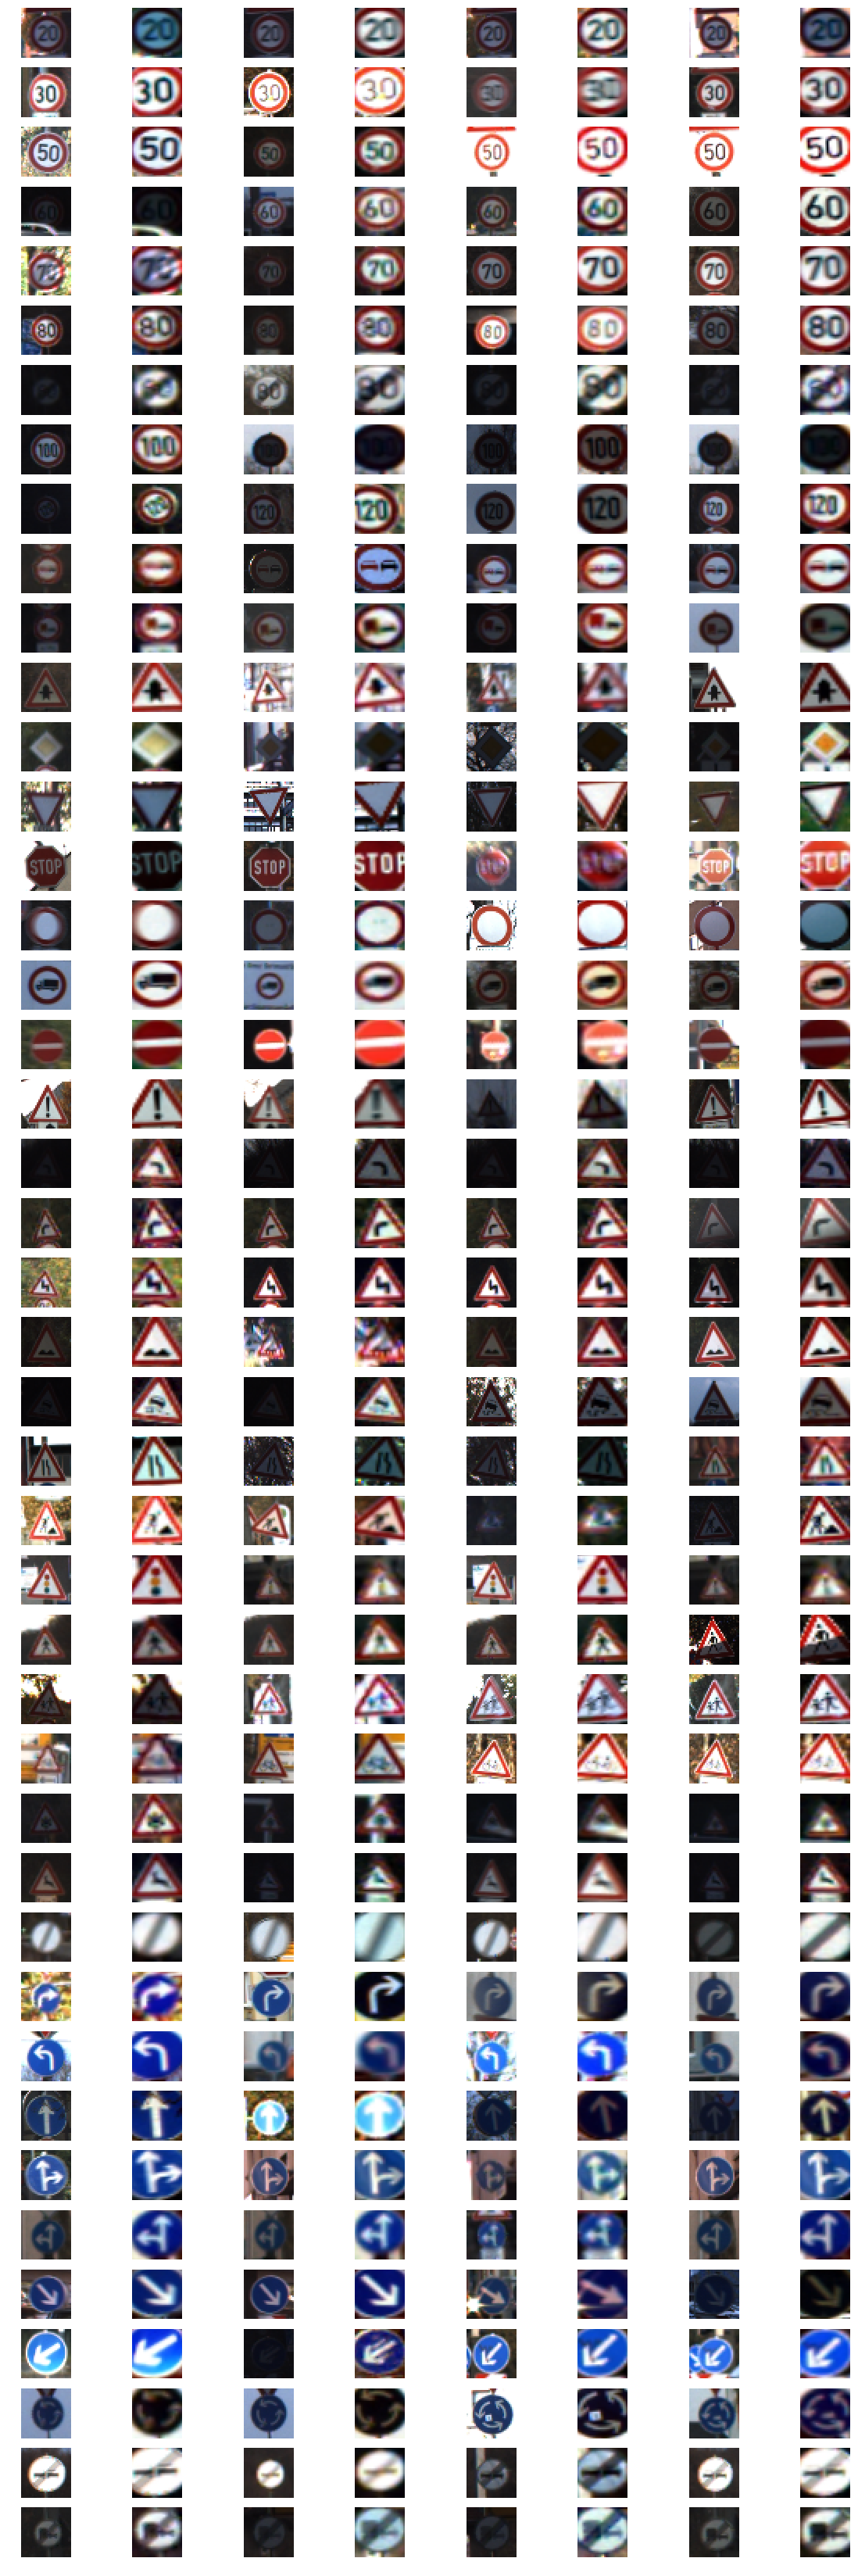

In [76]:
X = X_test
y = y_test

f, ax = plt.subplots(NUM_LABELS, 8, figsize=(20, 60))
for i in range(NUM_LABELS):
    
    ind = np.where(y == i)
    for j in range(4):

        x = X[ind][j]
        ax[i, j*2].imshow(x)
        ax[i, j*2].axis("off")

        stn_output = get_stn_output([x[np.newaxis, :], 0])[0]
        x = np.copy(stn_output[0])
        # x = (x - x.min())/(x.max() - x.min())
        for c in range(3):
            x_c = x[:, :, c]
            x[:, :, c] = (x_c - x_c.min())/(x_c.max() - x_c.min())
        ax[i, j*2 + 1].imshow(x)
        ax[i, j*2 + 1].axis("off")

In [8]:
model.layers[8].locnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 16)        2368      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 9, 9, 32)          12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 2, 64)          18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
__________

--- 

In [4]:
model = conv_model_no_color_adjust()
# model = conv_model()
model.load_weights("./keras_weights/stn_no-color-adjust_locnet_v3.hdf5")

get_stn_output = K.function([model.layers[0].input, K.learning_phase()],
                            [model.layers[1].output])

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 32, 32, 3)         0         
_________________________________________________________________
spatial_transformer_2 (Spati (None, 32, 32, 3)         294794    
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 32, 32, 16)        1216      
_________________________________________________________________
batch_normalization_15 (Batc (None, 32, 32, 16)        64        
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 32)        12832     
_________________________________________________________________
batch_normalization_16 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 32, 64)        51264     
__________

In [6]:
print(model.evaluate(X_train, to_categorical(y_train, NUM_LABELS)))
print(model.evaluate(X_test, to_categorical(y_test, NUM_LABELS)))
print(model.evaluate(X_val, to_categorical(y_val, NUM_LABELS)))

34799/34799 [==============================] - 18s 504us/step
[0.2006623558694732, 1.0]
12630/12630 [==============================] - 6s 469us/step
[0.26192737873451916, 0.9895486935583826]
4410/4410 [==============================] - 2s 485us/step
[0.2203784302451443, 0.9970521541950114]


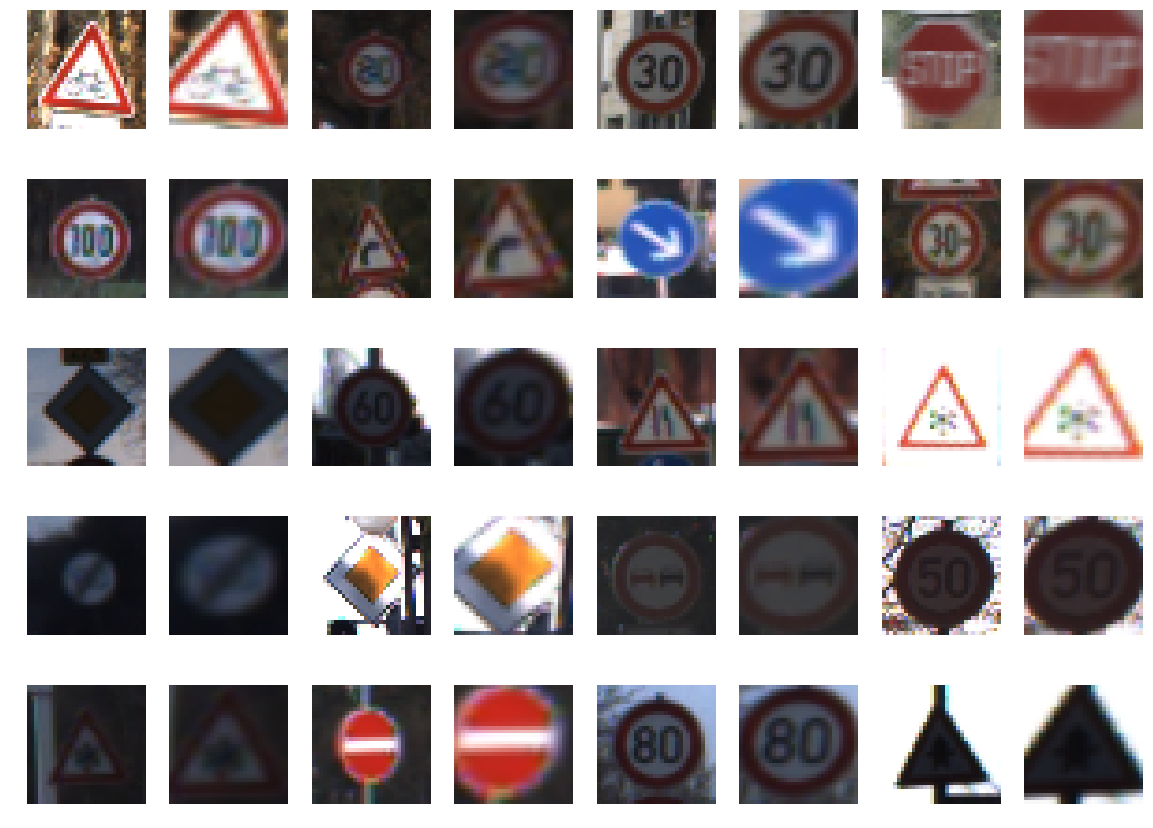

In [21]:
X = X_test
n = 20

f, ax = plt.subplots(int(np.ceil(n/4)), 8, figsize=(20, 15))
for i in range(n):
    
    ii = i//4
    jj = (i % 4)*2
    
    x = X[np.random.randint(len(X))]
    ax[ii, jj].imshow(x)
    ax[ii, jj].axis("off")
    
    stn_output = get_stn_output([x[np.newaxis, :], 0])[0]
    x = np.copy(stn_output[0])/2 + 0.5
#     x = (x - x.min())/(x.max() - x.min())
#     for c in range(3):
#         x_c = x[:, :, c]
#         x[:, :, c] = (x_c - x_c.min())/(x_c.max() - x_c.min())
    ax[ii, jj + 1].imshow(x)
    ax[ii, jj + 1].axis("off")

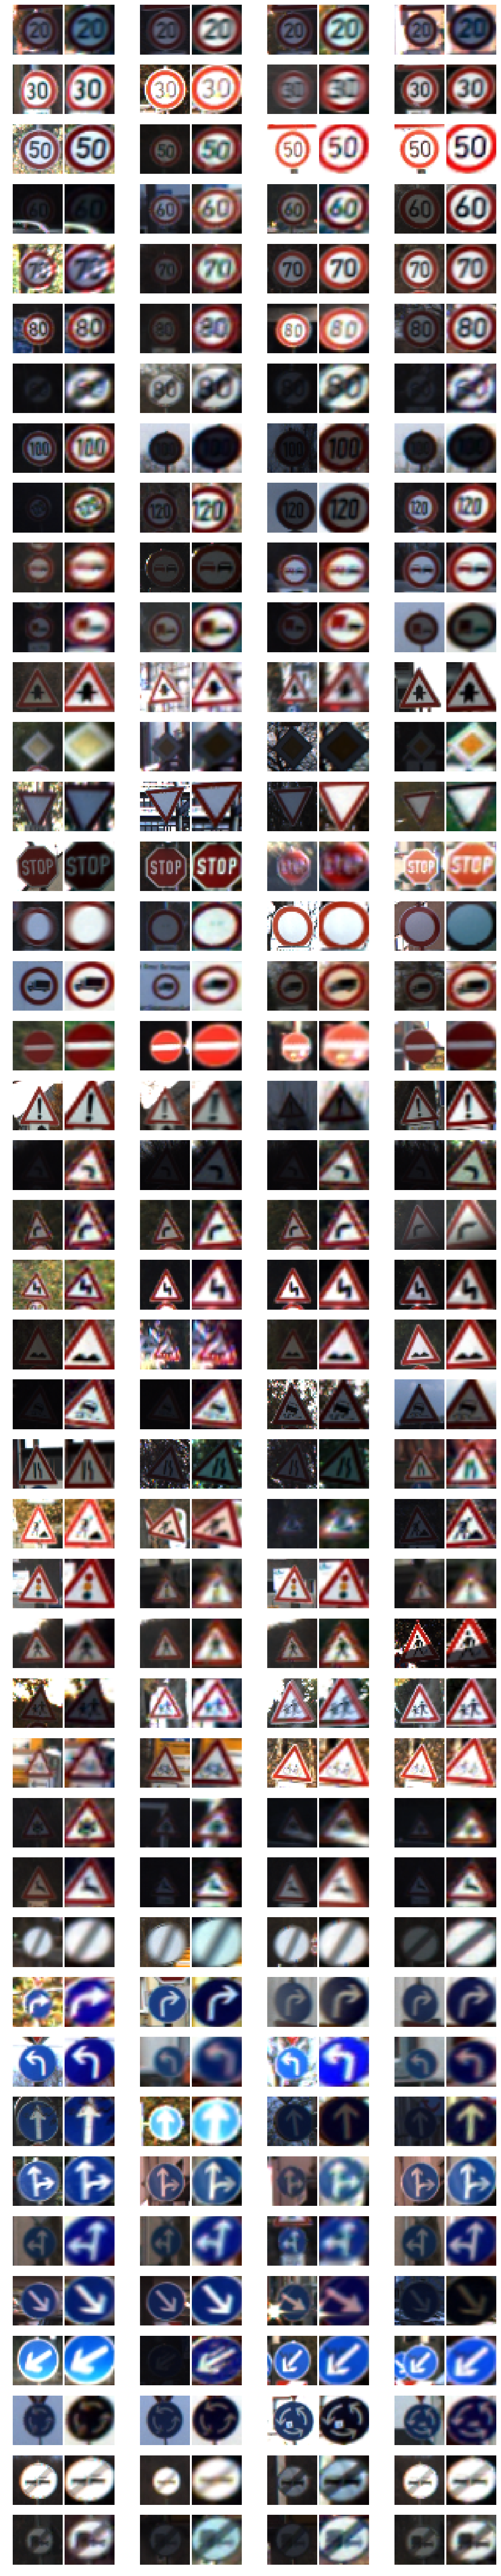

In [21]:
X = X_test
y = y_test

# f, ax = plt.subplots(NUM_LABELS, 8, figsize=(20, 60))
fig = plt.figure(figsize=(15, 100))

for j in range(4):
    
    left = j*0.25 + 0.05
    right = j*0.25 + 0.25
    gs = GridSpec(NUM_LABELS, 2)
    gs.update(left=left, right=right, wspace=0.05)
    for i in range(NUM_LABELS):

        ind = np.where(y == i)
        ax1 = plt.subplot(gs[i, 0])
        ax2 = plt.subplot(gs[i, 1])
        
        x = X[ind][j]
        ax1.imshow(x)
        ax1.axis("off")

        stn_output = get_stn_output([x[np.newaxis, :], 0])[0]
        x = np.copy(stn_output[0])
        # x = (x - x.min())/(x.max() - x.min())
        for c in range(3):
            x_c = x[:, :, c]
            x[:, :, c] = (x_c - x_c.min())/(x_c.max() - x_c.min())
        ax2.imshow(x)
        ax2.axis("off")
        
plt.savefig("stn_v3.png", bbox_inches="tight")

In [10]:
get_st_params = K.function([model.layers[1].locnet.input, K.learning_phase()],
                           [model.layers[1].locnet.output])

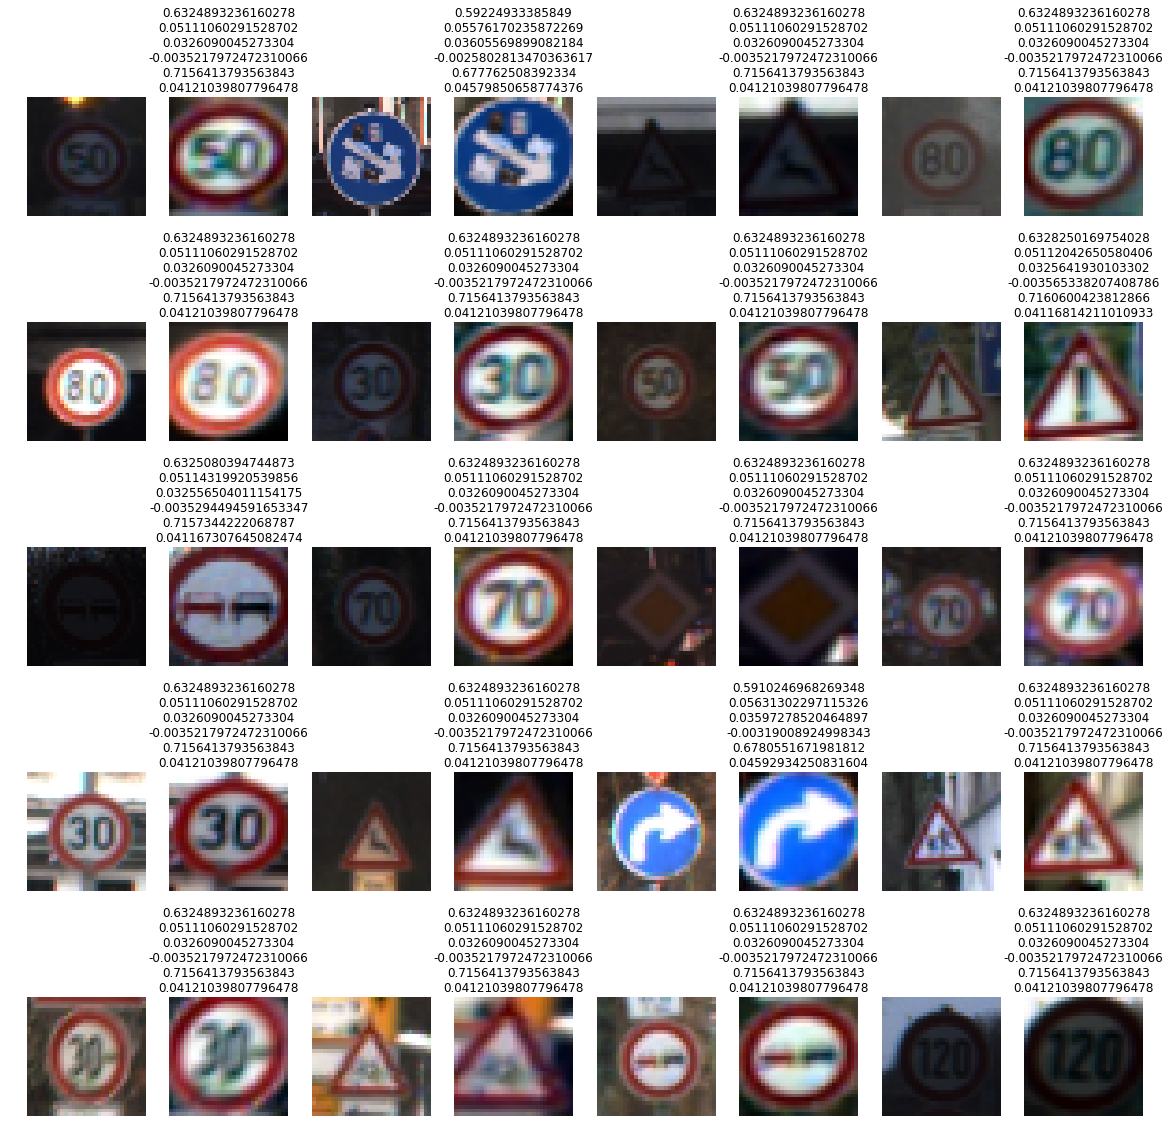

In [11]:
X = X_test
n = 20

f, ax = plt.subplots(int(np.ceil(n/4)), 8, figsize=(20, 20))
for i in range(n):
    
    ii = i//4
    jj = (i % 4)*2
    
    x = X[np.random.randint(len(X))]
    ax[ii, jj].imshow(x)
    ax[ii, jj].axis("off")
    
    param = get_st_params([x[np.newaxis, :], 0])[0]
    stn_output = get_stn_output([x[np.newaxis, :], 0])[0]
    x = np.copy(stn_output[0])
    # x = (x - x.min())/(x.max() - x.min())
    for c in range(3):
        x_c = x[:, :, c]
        x[:, :, c] = (x_c - x_c.min())/(x_c.max() - x_c.min())
    ax[ii, jj + 1].imshow(x)
    ax[ii, jj + 1].axis("off")
    ax[ii, jj + 1].set_title("{}\n{}\n{}\n{}\n{}\n{}".format(*param[0]))

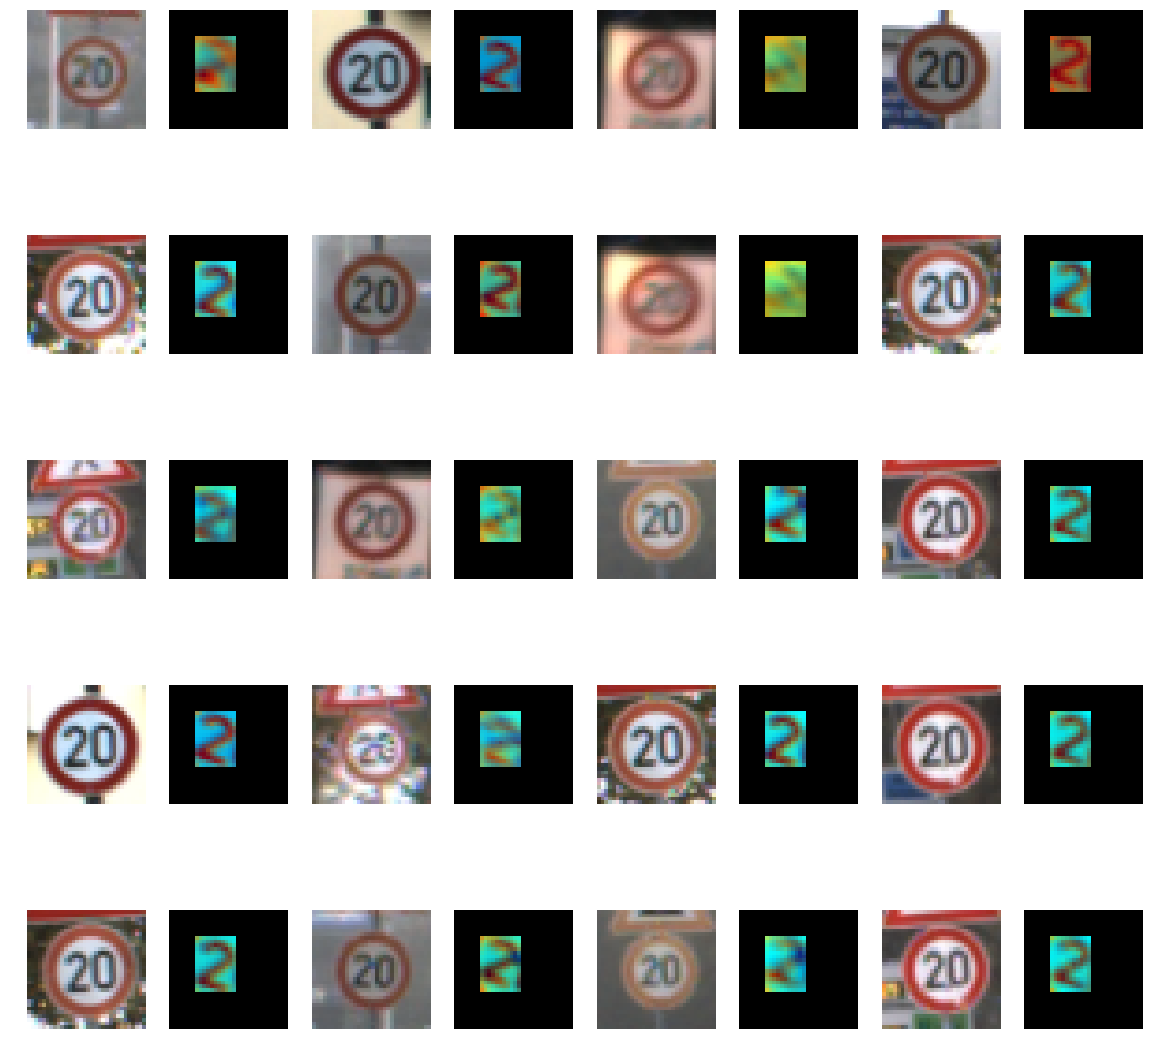

In [14]:
X = X_train
y = y_train
n = 20
y_label = 0
top, bot, left, right = 7, 22, 7, 18
ind = np.where(y == y_label)[0]
random.shuffle(ind)

f, ax = plt.subplots(int(np.ceil(n/4)), 8, figsize=(20, 20))
for i in range(n):
    
    ii = i//4
    jj = (i % 4)*2
    
    x = X[ind][i]
    ax[ii, jj].imshow(x)
    ax[ii, jj].axis("off")
    
    stn_output = get_stn_output([x[np.newaxis, :], 0])[0]
    x = np.copy(stn_output[0])
    # x = (x - x.min())/(x.max() - x.min())
    for c in range(3):
        x_c = x[:, :, c]
        x[:, :, c] = (x_c - x_c.min())/(x_c.max() - x_c.min())
#     ax[ii, jj].imshow(x)
#     ax[ii, jj].axis("off")
    
    x[:top, :] = 0
    x[bot:, :] = 0
    x[:, :left] = 0
    x[:, right:] = 0
    ax[ii, jj + 1].imshow(x)
    ax[ii, jj + 1].axis("off")

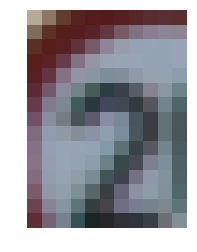

In [7]:
# crop '2': pos = 8, 23, 8, 17
# crop 'S': pos = 9, 23, 1, 9

def get_patch(X, pos):
    """
    Crop all samples in <X> to make a set of patches <X_cropped>
    at the same position <pos>
    """
    
    top, bot, left, right = pos
    X_cropped = np.zeros((X.shape[0], bot - top, right - left, X.shape[3]))
    for i, x in enumerate(X):
        X_cropped[i] = np.copy(x[top:bot, left:right, :])
    return X_cropped

# Test get_patch
X_2 = get_patch(X_train, (7, 22, 7, 18))
plt.imshow(X_2[np.where(y_train == 0)][0])
plt.axis("off")
plt.show()

In [8]:
# Define cropping positions
pos_2 = (8, 23, 8, 17)
pos_S = (9, 23, 1, 9)
# pos_2 = (7, 22, 7, 18)
# pos_S = (4, 19, 0, 9)

In [130]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda
from keras.layers import Conv2D, MaxPooling2D, Cropping2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
# from stn.conv_model import output_fn

def output_fn(correct, predicted):
    return tf.nn.softmax_cross_entropy_with_logits_v2(labels=correct,
                                                      logits=predicted)

def create_simple_cnn(pos):
    
    top, bot, left, right = pos
    height = bot - top
    width = right - left
    
    model = Sequential()
    model.add(Cropping2D(cropping=((top, 32 - bot), (left, 32 - right)), 
                         input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
#     model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(height, width, 3)))
    model.add(Conv2D(16, (3, 3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
#     model.add(Flatten())
#     model.add(Dense(100, activation='relu'))
#     model.add(Dense(100, activation='relu'))
    model.add(Dense(2))
    
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, 
                epsilon=1e-08, decay=0.0)
#     model.compile(loss=output_fn, optimizer=adam, metrics=['accuracy'])
#     model.compile(loss=weighted_logistic_loss, optimizer=adam, 
#                   metrics=[keras.metrics.binary_accuracy])
    model.compile(loss=weighted_cross_entropy_loss, optimizer=adam, metrics=['accuracy'])
    return model


def train_simple_cnn(stn_fnc, pos, y, X_train, y_train, X_val, y_val,
                     save_path="./keras_weights/temp.hdf5"):
    
    # ------- Prepare training and test sets ------- #
    # Transform with stn
    X_train_d = stn_fnc([X_train, 0])[0]
    X_val_d = stn_fnc([X_val, 0])[0]
    
#     X_train_d = get_patch(X_train_d, pos)
#     X_val_d = get_patch(X_val_d, pos)

    # Zero mean for each image
#     X_train_d -= np.mean(X_train_d, axis=(1, 2, 3), keepdims=True)
#     X_val_d -= np.mean(X_val_d, axis=(1, 2, 3), keepdims=True)
    
    # Get training and test labels
    y_train_d = (y_train == y).astype(int)
    y_val_d = (y_val == y).astype(int)
    y_train_d = to_categorical(y_train_d, 2)
    y_val_d = to_categorical(y_val_d, 2)
    
    # ---------------- Train model ----------------- #
    checkpointer = ModelCheckpoint(
        filepath=save_path, verbose=1, save_best_only=True, 
        save_weights_only=True)
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5,
                              verbose=0, mode='auto', baseline=None)
    
    model = create_simple_cnn(pos)
#     model.load_weights(save_path)
#     adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.01)
#     model.compile(loss=output_fn, optimizer=adam, metrics=['accuracy'])
#     model.fit(X_train_d, y_train_d,
#               batch_size=128,
#               epochs=40,
#               verbose=1,
#               shuffle=True,
#               callbacks=[checkpointer, earlystop],
#               validation_data=(X_val_d, y_val_d))
#     print("Train: ", model.evaluate(X_train_d, y_train_d))
#     print("Val: ", model.evaluate(X_val_d, y_val_d))
#     model.save_weights("./keras_weights/temp_S.hdf5")

    X_train_d, y_train_d = gen_balance_data(X_train_d, y_train, y, r=10)
    X_val_d, y_val_d = gen_balance_data(X_val_d, y_val, y, r=10)
    
    model.load_weights("./keras_weights/temp.hdf5")
    checkpointer = ModelCheckpoint(
        filepath=save_path, verbose=1, save_best_only=True, 
        save_weights_only=True)
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5,
                              verbose=0, mode='auto', baseline=None)
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    
#     for layer in model.layers[:-2]:
#         layer.trainable = False
    
    model.compile(loss=weighted_cross_entropy_loss, optimizer=adam, metrics=['accuracy'])
    print("Train: ", model.evaluate(X_train_d, y_train_d))
    print("Val: ", model.evaluate(X_val_d, y_val_d))
    model.fit(X_train_d, y_train_d,
              batch_size=32,
              epochs=40,
              verbose=1,
              shuffle=True,
              callbacks=[checkpointer, earlystop],
              validation_data=(X_val_d, y_val_d))
    
#     datagen = ImageDataGenerator(
#         rotation_range=5,
#         width_shift_range=0.1,
#         height_shift_range=0.1,
#         zoom_range=0.1)
#     for i in range(10):
#         x = X_train_d[40000 + i]
#         plt.imshow(x/2 + 0.5)
#         plt.show()
#         x = datagen.random_transform(x)
#         plt.imshow(x/2 + 0.5)
#         plt.show()
#     model.fit_generator(datagen.flow(X_train_d, y_train_d, batch_size=32),
#                         steps_per_epoch=len(X_train)/32, epochs=20,
#                         verbose=1, shuffle=True,
#                         callbacks=[checkpointer, earlystop],
#                         validation_data=(X_val_d, y_val_d))
    
    model.load_weights(save_path)
    print("Train: ", model.evaluate(X_train_d, y_train_d)[1])
    print("Val: ", model.evaluate(X_val_d, y_val_d)[1])
    
    return model


def eval_simple_cnn(model, stn_fnc, y, X_test, y_test):
    
    X_test_d = stn_fnc([X_test, 0])[0]
    
#     X_test_d = get_patch(X_test_d, (8, 23, 8, 17))
#     X_test_d -= np.mean(X_test_d, axis=(1, 2, 3), keepdims=True)
    
    y_test_d = (y_test == y).astype(int)
    y_pred = model.predict(X_test_d)
    y_pred = np.argmax(y_pred, axis=-1)
    acc = np.sum(y_pred == y_test_d) / len(y_pred)
    fpr = np.sum(np.logical_and(y_pred != y_test_d, y_test_d == 0)) / np.sum(y_test_d == 0)
    fnr = np.sum(np.logical_and(y_pred != y_test_d, y_test_d == 1)) / np.sum(y_test_d == 1)
    
    return acc, fpr, fnr


def weighted_logistic_loss(y_true, y_pred):
    
    WEIGHT_RATIO = 10
    
    # Scale true label to (-1, 1)
    # y_true_s = tf.argmax(y_true, axis=-1)
    # y_true_s = tf.cast(y_true_s*2 - 1, tf.float32)
    # Sigmoid
    # y_pred_s = tf.sigmoid(y_pred)
    #loss = tf.log(1 + tf.exp(-1*tf.multiply(y_true_s, y_pred_s))) / np.log(2)
    #weight = tf.where(y_true - y_pred == 1, WEIGHT_RATIO, 1)
    #loss = tf.multiply(loss, tf.cast(weight, tf.float32))
    # loss = tf.losses.log_loss(y_true, y_pred_s, weights=1.0)
    
    class_weights = tf.constant([[1.0, WEIGHT_RATIO]])
    weights = tf.reduce_sum(class_weights * y_true, axis=-1)
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred)
    #loss = weights * loss
    return loss


def weighted_cross_entropy_loss(y_true, y_pred):
    
    WEIGHT_RATIO = 9.
    
    class_weights = tf.constant([[1.0, WEIGHT_RATIO]])
    weights = tf.reduce_sum(class_weights * y_true, axis=-1)
    loss = tf.nn.softmax_cross_entropy_with_logits_v2(
        labels=y_true, logits=y_pred)
    loss = weights * loss
    return tf.reduce_mean(loss)


def gen_balance_data(X_train, y_train, y, r=2):
    
    n_d = np.where(y_train == y)[0].shape[0]
    X_eq = np.zeros((n_d*r, 32, 32, 3))
    X_eq[:n_d] = np.copy(X_train[np.where(y_train == y)])
    ind = np.where(y_train != y)[0]
    np.random.shuffle(ind)
    X_eq[n_d:] = np.copy(X_train[ind[:(r - 1)*n_d]])
    y_eq = np.zeros(n_d*r)
    y_eq[:n_d] = 1
    y_eq = to_categorical(y_eq, 2) 
    
    return X_eq, y_eq

In [82]:
model_S = train_simple_cnn(get_stn_output, pos_S, 14, 
                           X_train, y_train, 
                           X_val, y_val,
                           save_path="./keras_weights/S_STOP_v7.hdf5")

1380/1380 [==============================] - 2s 2ms/step
Train:  [0.3408038225775733, 0.9036231884057971]
180/180 [==============================] - 0s 126us/step
Val:  [0.8066599820649976, 0.8055555555555556]
Train on 1380 samples, validate on 180 samples
Epoch 1/40
1380/1380 [==============================] - 3s 2ms/step - loss: 0.9280 - acc: 0.7681 - val_loss: 1.1864 - val_acc: 0.7333

Epoch 00001: val_loss improved from inf to 1.18635, saving model to ./keras_weights/S_STOP_v7.hdf5
Epoch 2/40
1380/1380 [==============================] - 1s 379us/step - loss: 0.6742 - acc: 0.8138 - val_loss: 0.9198 - val_acc: 0.7556

Epoch 00002: val_loss improved from 1.18635 to 0.91976, saving model to ./keras_weights/S_STOP_v7.hdf5
Epoch 3/40
1380/1380 [==============================] - 1s 378us/step - loss: 0.5772 - acc: 0.8370 - val_loss: 0.7147 - val_acc: 0.7833

Epoch 00003: val_loss improved from 0.91976 to 0.71474, saving model to ./keras_weights/S_STOP_v7.hdf5
Epoch 4/40
1380/1380 [=======

In [13]:
# weighted
print(eval_simple_cnn(model_S, get_stn_output, 14, X_train, y_train))
print(eval_simple_cnn(model_S, get_stn_output, 14, X_val, y_val))
print(eval_simple_cnn(model_S, get_stn_output, 14, X_test, y_test))

(0.9831316991867582, 0.017209534140549414, 0.0)
(0.9668934240362812, 0.03333333333333333, 0.022222222222222223)
(0.9859065716547902, 0.013915857605177993, 0.022222222222222223)


In [67]:
# transfer, weighted, lr 1e-4
print(eval_simple_cnn(model_S, get_stn_output, 14, X_train, y_train))
print(eval_simple_cnn(model_S, get_stn_output, 14, X_val, y_val))
print(eval_simple_cnn(model_S, get_stn_output, 14, X_test, y_test))

(0.9866950199718383, 0.013515494444281568, 0.002898550724637681)
(0.9736961451247166, 0.026157407407407407, 0.03333333333333333)
(0.9900237529691212, 0.0093042071197411, 0.040740740740740744)


In [76]:
# transfer, weighted, lr 1e-4, decay 0.01
print(eval_simple_cnn(model_S, get_stn_output, 14, X_train, y_train))
print(eval_simple_cnn(model_S, get_stn_output, 14, X_val, y_val))
print(eval_simple_cnn(model_S, get_stn_output, 14, X_test, y_test))

(0.9773556711399752, 0.022838547011052802, 0.013043478260869565)
(0.9587301587301588, 0.04027777777777778, 0.08888888888888889)
(0.9823436262866192, 0.016423948220064724, 0.07407407407407407)


In [73]:
# transfer, weighted, lr 1e-5
print(eval_simple_cnn(model_S, get_stn_output, 14, X_train, y_train))
print(eval_simple_cnn(model_S, get_stn_output, 14, X_val, y_val))
print(eval_simple_cnn(model_S, get_stn_output, 14, X_test, y_test))

(0.9791660679904595, 0.021138116039754903, 0.005797101449275362)
(0.9616780045351474, 0.03726851851851852, 0.08888888888888889)
(0.9836896278701505, 0.0156957928802589, 0.044444444444444446)


In [61]:
# eq
print(eval_simple_cnn(model_S, get_stn_output, 14, X_train, y_train))
print(eval_simple_cnn(model_S, get_stn_output, 14, X_val, y_val))
print(eval_simple_cnn(model_S, get_stn_output, 14, X_test, y_test))

(0.9753441190838817, 0.02477352018528834, 0.01884057971014493)
(0.9619047619047619, 0.03726851851851852, 0.07777777777777778)
(0.967458432304038, 0.031067961165048542, 0.1)


In [64]:
# transfer, eq, lr 1e-4
print(eval_simple_cnn(model_S, get_stn_output, 14, X_train, y_train))
print(eval_simple_cnn(model_S, get_stn_output, 14, X_val, y_val))
print(eval_simple_cnn(model_S, get_stn_output, 14, X_test, y_test))

(0.9891376188970947, 0.011082119088803542, 0.0)
(0.9752834467120182, 0.024537037037037038, 0.03333333333333333)
(0.9889944576405384, 0.010922330097087379, 0.014814814814814815)


In [80]:
# transfer, eq, lr 1e-4, decay 0.01
print(eval_simple_cnn(model_S, get_stn_output, 14, X_train, y_train))
print(eval_simple_cnn(model_S, get_stn_output, 14, X_val, y_val))
print(eval_simple_cnn(model_S, get_stn_output, 14, X_test, y_test))

(0.9874996407942757, 0.012635961183265414, 0.005797101449275362)
(0.9761904761904762, 0.022685185185185187, 0.07777777777777778)
(0.9888361045130641, 0.010113268608414239, 0.05925925925925926)


In [83]:
# transfer, eq, lr 1e-5
print(eval_simple_cnn(model_S, get_stn_output, 14, X_train, y_train))
print(eval_simple_cnn(model_S, get_stn_output, 14, X_val, y_val))
print(eval_simple_cnn(model_S, get_stn_output, 14, X_test, y_test))

(0.9877295324578292, 0.011463250168577209, 0.05217391304347826)
(0.9811791383219954, 0.016666666666666666, 0.12222222222222222)
(0.9884402216943785, 0.00784789644012945, 0.1814814814814815)


In [133]:
model_2 = train_simple_cnn(get_stn_output, pos_2, 0, 
                           X_train, y_train, 
                           X_val, y_val,
                           save_path="./keras_weights/2_speed20_v8.hdf5")

1800/1800 [==============================] - 5s 3ms/step
Train:  [1.2962782759733575, 0.9544444444444444]
300/300 [==============================] - 0s 239us/step
Val:  [2.287501871387164, 0.9233333333333333]
Train on 1800 samples, validate on 300 samples
Epoch 1/40
1800/1800 [==============================] - 5s 3ms/step - loss: 0.7278 - acc: 0.9606 - val_loss: 0.3851 - val_acc: 0.9733

Epoch 00001: val_loss improved from inf to 0.38514, saving model to ./keras_weights/2_speed20_v8.hdf5
Epoch 2/40
1800/1800 [==============================] - 1s 457us/step - loss: 0.2667 - acc: 0.9517 - val_loss: 0.2907 - val_acc: 0.9800

Epoch 00002: val_loss improved from 0.38514 to 0.29069, saving model to ./keras_weights/2_speed20_v8.hdf5
Epoch 3/40
1800/1800 [==============================] - 1s 469us/step - loss: 0.2369 - acc: 0.9606 - val_loss: 0.3215 - val_acc: 0.9867

Epoch 00003: val_loss did not improve from 0.29069
Epoch 4/40
1800/1800 [==============================] - 1s 451us/step - loss

In [134]:
# transfer, eq + weighted (r=10), lr 1e-4 (r=10 for val)
print(eval_simple_cnn(model_2, get_stn_output, 0, X_train, y_train))
print(eval_simple_cnn(model_2, get_stn_output, 0, X_val, y_val))
print(eval_simple_cnn(model_2, get_stn_output, 0, X_test, y_test))

(0.9786775482054082, 0.021404431092752536, 0.005555555555555556)
(0.9891156462585035, 0.010730593607305937, 0.03333333333333333)
(0.9702296120348377, 0.029912490055688145, 0.0)


In [129]:
# transfer, eq + weighted (r=10), lr 1e-4
print(eval_simple_cnn(model_2, get_stn_output, 0, X_train, y_train))
print(eval_simple_cnn(model_2, get_stn_output, 0, X_val, y_val))
print(eval_simple_cnn(model_2, get_stn_output, 0, X_test, y_test))

(0.9779304002988591, 0.022126577890753632, 0.011111111111111112)
(0.9873015873015873, 0.012557077625570776, 0.03333333333333333)
(0.9682501979414093, 0.031901352426412094, 0.0)


In [122]:
# transfer, eq + weighted (r=10), lr 1e-4 (fluke)
print(eval_simple_cnn(model_2, get_stn_output, 0, X_train, y_train))
print(eval_simple_cnn(model_2, get_stn_output, 0, X_val, y_val))
print(eval_simple_cnn(model_2, get_stn_output, 0, X_test, y_test))

(0.9858616626914567, 0.014211848984661601, 0.0)
(0.9938775510204082, 0.005936073059360731, 0.03333333333333333)
(0.9790973871733967, 0.02092283214001591, 0.016666666666666666)


In [110]:
# transfer, eq (r=10), lr 1e-4
print(eval_simple_cnn(model_2, get_stn_output, 0, X_train, y_train))
print(eval_simple_cnn(model_2, get_stn_output, 0, X_val, y_val))
print(eval_simple_cnn(model_2, get_stn_output, 0, X_test, y_test))

(0.9971263542055806, 0.0028885871920043904, 0.0)
(0.9979591836734694, 0.0018264840182648401, 0.03333333333333333)
(0.9922406967537609, 0.00771678599840891, 0.016666666666666666)


In [115]:
# transfer, eq (r=10), lr 1e-4, decay 0.01
print(eval_simple_cnn(model_2, get_stn_output, 0, X_train, y_train))
print(eval_simple_cnn(model_2, get_stn_output, 0, X_val, y_val))
print(eval_simple_cnn(model_2, get_stn_output, 0, X_test, y_test))

(0.9970976177476364, 0.0027441578324041713, 0.03333333333333333)
(0.9977324263038548, 0.0009132420091324201, 0.2)
(0.9919239904988123, 0.006603023070803501, 0.31666666666666665)


In [107]:
# transfer, eq (r=5), lr 1e-4
print(eval_simple_cnn(model_2, get_stn_output, 0, X_train, y_train))
print(eval_simple_cnn(model_2, get_stn_output, 0, X_val, y_val))
print(eval_simple_cnn(model_2, get_stn_output, 0, X_test, y_test))

(0.9915227449064629, 0.00843467460065282, 0.016666666666666666)
(0.9954648526077098, 0.00410958904109589, 0.06666666666666667)
(0.9842438638163103, 0.015592680986475736, 0.05)


In [52]:
# transfer, eq, lr 1e-4
print(eval_simple_cnn(model_2, get_stn_output, 0, X_train, y_train))
print(eval_simple_cnn(model_2, get_stn_output, 0, X_val, y_val))
print(eval_simple_cnn(model_2, get_stn_output, 0, X_test, y_test))

(0.9730739389062905, 0.027037176117161096, 0.005555555555555556)
(0.9863945578231292, 0.013242009132420091, 0.06666666666666667)
(0.9635787806809184, 0.03659506762132061, 0.0)


In [102]:
# transfer, eq, lr 1e-4
print(eval_simple_cnn(model_2, get_stn_output, 0, X_train, y_train))
print(eval_simple_cnn(model_2, get_stn_output, 0, X_val, y_val))
print(eval_simple_cnn(model_2, get_stn_output, 0, X_test, y_test))

(0.9741084513922814, 0.02602617059995956, 0.0)
(0.9893424036281179, 0.010273972602739725, 0.06666666666666667)
(0.9676167854315123, 0.03237867939538584, 0.03333333333333333)


In [95]:
# transfer, eq, lr 1e-4, decay 0.01
print(eval_simple_cnn(model_2, get_stn_output, 0, X_train, y_train))
print(eval_simple_cnn(model_2, get_stn_output, 0, X_val, y_val))
print(eval_simple_cnn(model_2, get_stn_output, 0, X_test, y_test))

(0.959079283887468, 0.04110459574222248, 0.005555555555555556)
(0.9693877551020408, 0.030365296803652967, 0.06666666666666667)
(0.9541567695961995, 0.04606205250596659, 0.0)


In [89]:
# transfer, eq, lr 1e-5
print(eval_simple_cnn(model_2, get_stn_output, 0, X_train, y_train))
print(eval_simple_cnn(model_2, get_stn_output, 0, X_val, y_val))
print(eval_simple_cnn(model_2, get_stn_output, 0, X_test, y_test))

(0.9818098221213253, 0.018198099309627663, 0.016666666666666666)
(0.990702947845805, 0.00821917808219178, 0.16666666666666666)
(0.9732383214568487, 0.026332537788385044, 0.11666666666666667)


In [59]:
# eq
print(eval_simple_cnn(model_2, get_stn_output, 0, X_train, y_train))
print(eval_simple_cnn(model_2, get_stn_output, 0, X_val, y_val))
print(eval_simple_cnn(model_2, get_stn_output, 0, X_test, y_test))

(0.9456306215695853, 0.05462318380080303, 0.005555555555555556)
(0.9514739229024943, 0.048401826484018265, 0.06666666666666667)
(0.9460015835312747, 0.05401750198886237, 0.05)


In [24]:
# transfer, weighted
print(eval_simple_cnn(model_2, get_stn_output, 0, X_train, y_train))
print(eval_simple_cnn(model_2, get_stn_output, 0, X_val, y_val))
print(eval_simple_cnn(model_2, get_stn_output, 0, X_test, y_test))

(0.9522400068967499, 0.048008319131112975, 0.0)
(0.9698412698412698, 0.030365296803652967, 0.0)
(0.9468725257323832, 0.053381066030230705, 0.0)


In [ ]:
model_2.summary()

In [88]:
model_2.load_weights("./keras_weights/2_speed20_v3.hdf5")

In [88]:
model_S.load_weights("./keras_weights/S_STOP_v1.hdf5")

In [16]:
# y = 0
# r = 2
# n_d = np.where(y_train == y)[0].shape[0]

# X_eq = np.zeros((n_d*r, 32, 32, 3))
# X_eq[:n_d] = np.copy(X_train[np.where(y_train == y)])

# ind = np.where(y_train != y)[0]
# np.random.shuffle(ind)
# X_eq[n_d:] = X_train[ind[:(r - 1)*n_d]]

# y_eq = np.zeros(n_d*r)
# y_eq[:n_d] = y
# y_eq[n_d:] = y_train[ind[:(r - 1)*n_d]]

y = 0
r = 100
n_train = len(y_train)
n_d = np.where(y_train == y)[0].shape[0]

X_eq = np.zeros((n_d*r + n_train, 32, 32, 3))
X_eq[:n_train] = np.copy(X_train)

ind = np.where(y_train == y)[0]
X_eq[n_train:] = np.tile(X_train[ind], (r, 1, 1, 1))

y_eq = np.zeros(n_d*r + len(y_train))
y_eq[:n_train] = np.copy(y_train)
y_eq[n_train:] = y

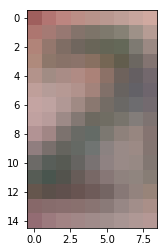

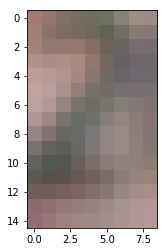

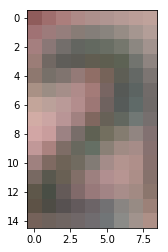

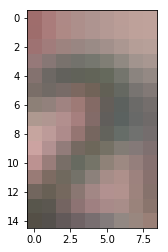

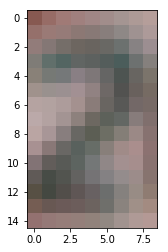

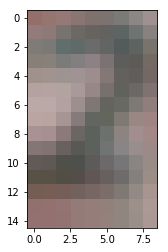

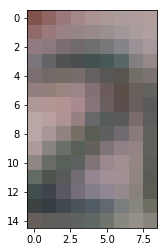

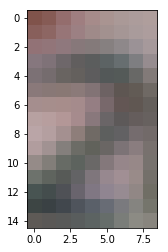

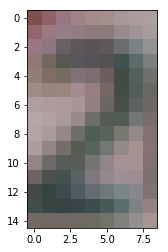

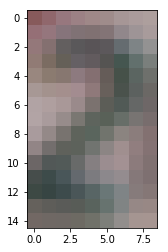

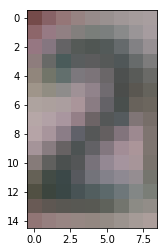

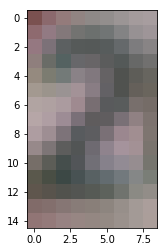

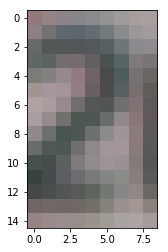

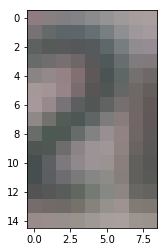

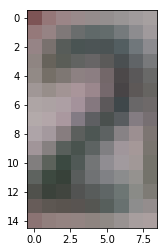

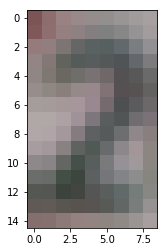

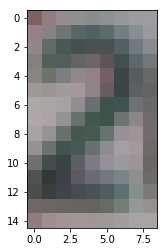

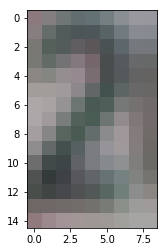

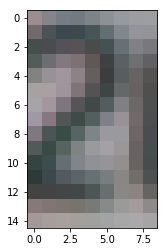

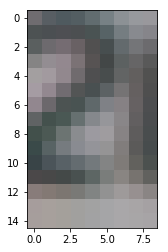

Epoch 1/20
1650/1649 [==============================] - 18s 11ms/step - loss: 0.0456 - acc: 0.9845 - val_loss: 0.0072 - val_acc: 0.9982

Epoch 00001: val_loss improved from inf to 0.00718, saving model to ./keras_weights/2_speed20_v5.hdf5
Epoch 2/20
 905/1649 [===============>..............] - ETA: 7s - loss: 0.0175 - acc: 0.9951

KeyboardInterrupt: 

In [31]:
model_2 = train_simple_cnn(get_stn_output, pos_2, 0, 
                           X_eq, y_eq, 
                           X_val, y_val,
                           save_path="./keras_weights/2_speed20_v5.hdf5")

In [27]:
eval_simple_cnn(model_2, get_stn_output, 0, X_test, y_test)

(0.9959619952494062, 0.0016706443914081145, 0.5)

In [13]:
y = 17
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
acc = np.sum(np.logical_and(y_pred == y_test, y_test == y)) / np.sum(y_test == y)
fpr = np.sum(np.logical_and(y_pred != y_test, y_pred == y)) / np.sum(y_test != y)
fnr = np.sum(np.logical_and(y_pred != y_test, y_test == y)) / np.sum(y_test == y)
print(acc, fpr, fnr)

0.9166666666666666 0.0 0.08333333333333333


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


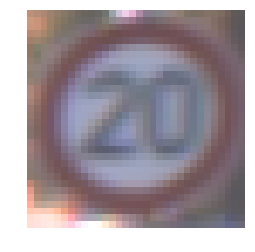

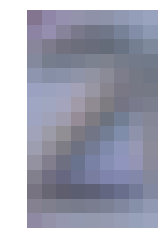

[ 1.1460507 -1.0914409]


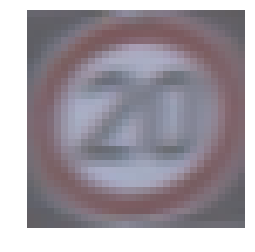

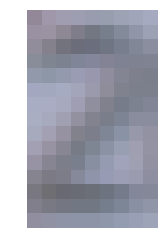

[ 0.82222193 -0.7004645 ]


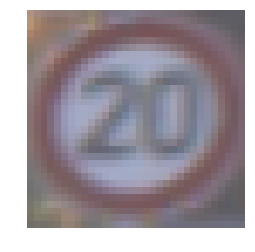

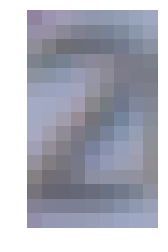

[ 0.92203    -0.86855876]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


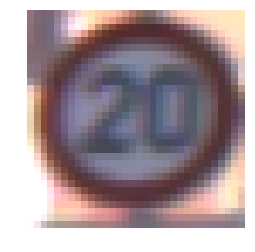

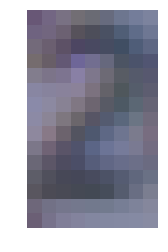

[ 2.8942792 -2.3722243]


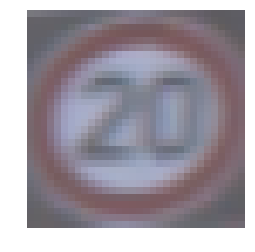

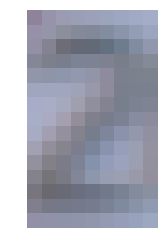

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 0.69797087 -0.81188107]


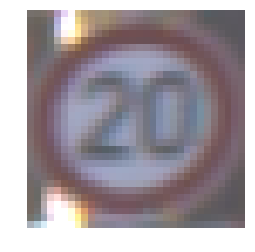

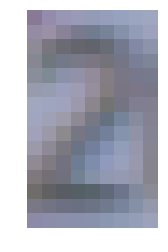

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-0.18243192  0.00495511]


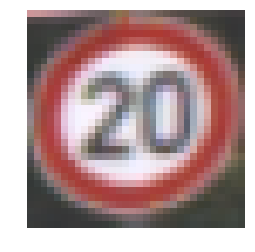

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


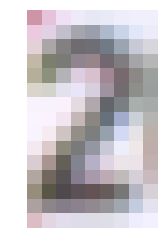

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-2.523607   1.8657633]


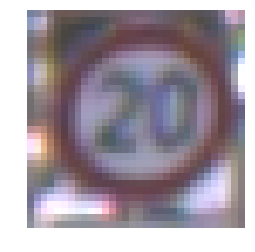

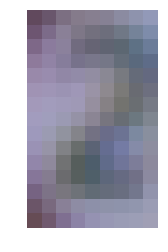

[ 2.7304847 -2.1502137]


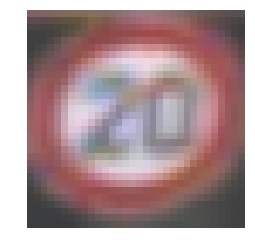

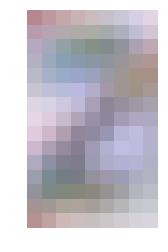

[ 1.4481025 -1.588954 ]


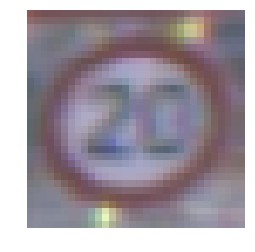

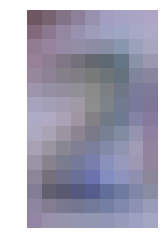

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 0.6423258 -0.7094046]


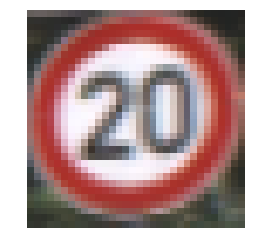

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


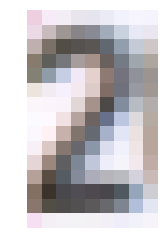

[-3.8010995  2.9277155]


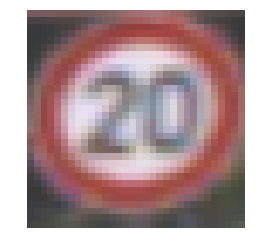

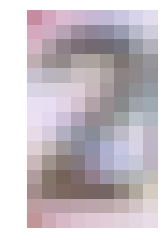

[ 0.1634678  -0.37408134]


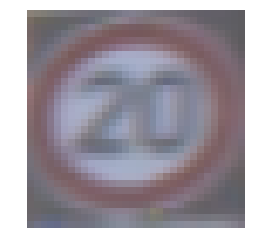

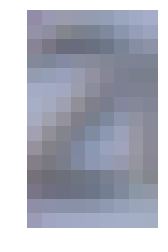

[ 0.4112297  -0.56815505]


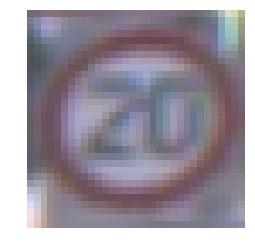

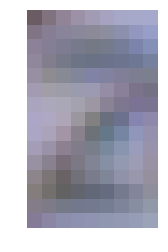

[ 0.1334721  -0.30891436]


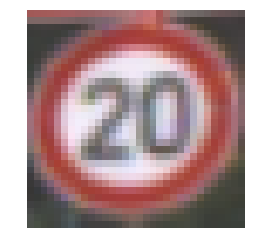

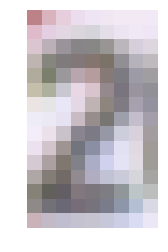

[-2.2248375  1.4768543]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


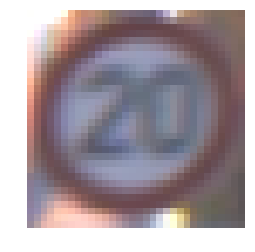

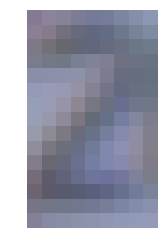

[ 1.0267386 -1.0210723]


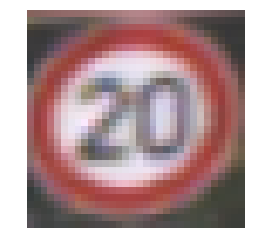

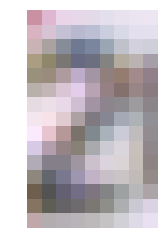

[-2.3219943  1.7447642]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


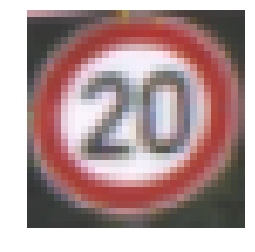

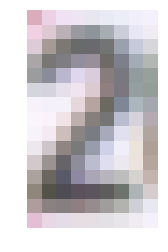

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-2.234129   1.6814032]


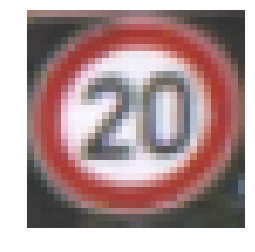

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


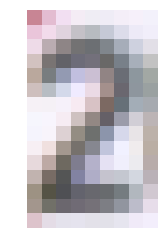

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-2.8252923  2.3408914]


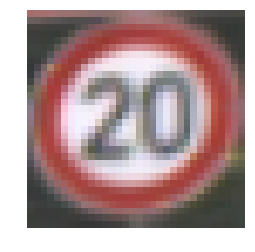

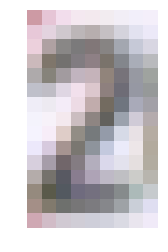

[-2.215758   1.8033059]


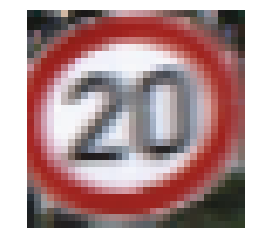

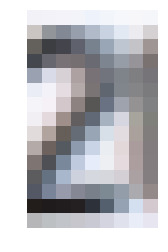

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-2.7644053  1.5216446]


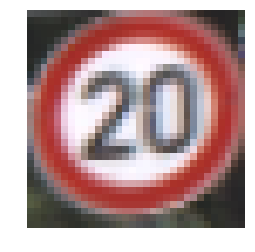

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


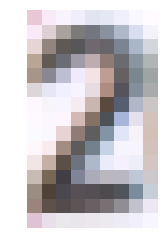

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-2.3876157  2.2154431]


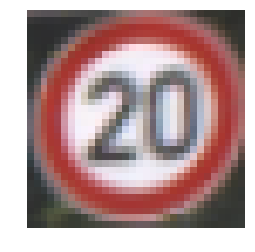

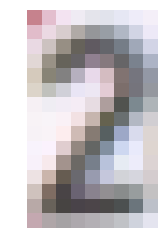

[-0.59546834  0.34625578]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


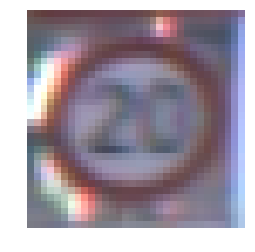

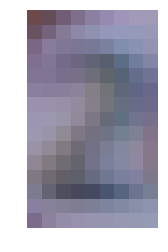

[ 0.1522527  -0.50090057]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


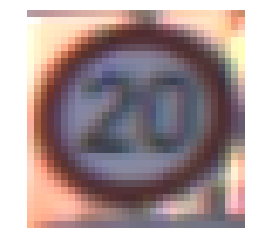

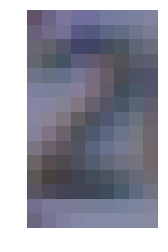

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 2.7552843 -2.5105953]


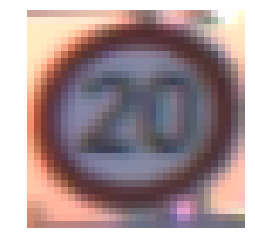

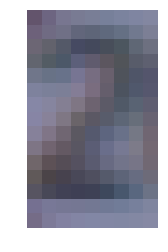

[ 2.4852717 -2.2714055]


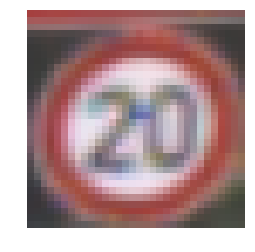

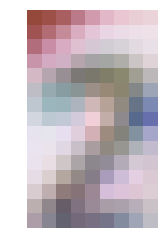

[ 2.1934817 -1.946604 ]


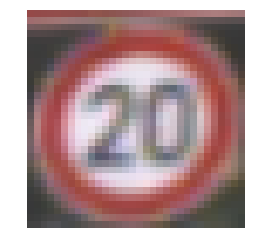

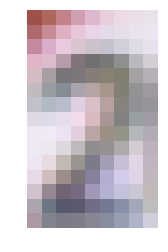

[ 0.08444455 -0.7971096 ]


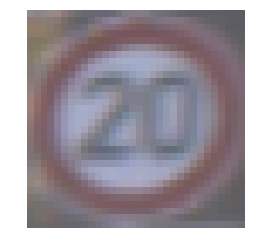

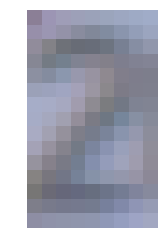

[ 0.8281234  -0.84234965]


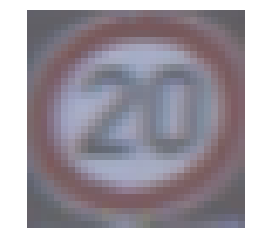

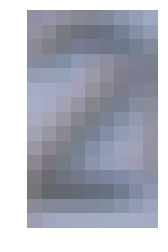

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 0.7656475 -0.6196582]


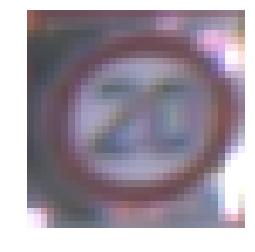

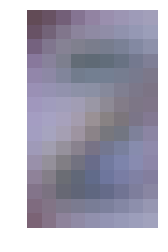

[ 2.2035482 -2.013373 ]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


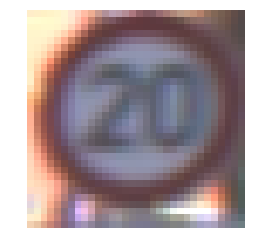

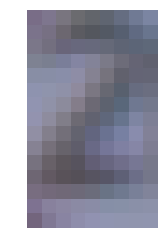

[ 2.264561  -1.7256367]


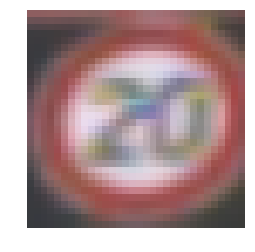

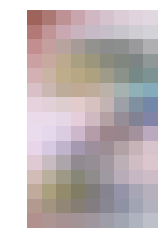

[ 3.6244688 -3.2271643]


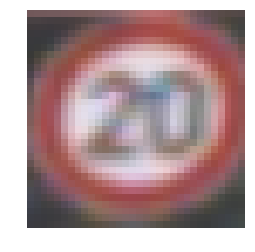

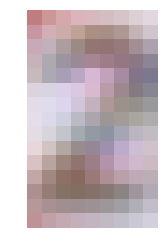

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 1.8287948 -1.58344  ]


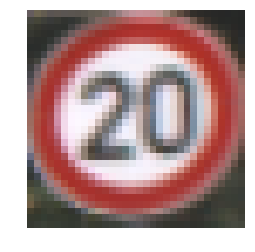

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


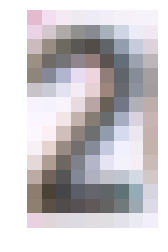

[-3.3915906  2.9981937]


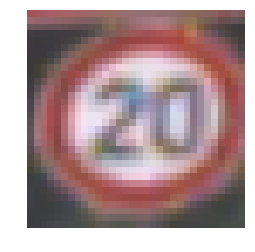

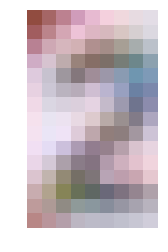

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 1.6096686 -1.4251764]


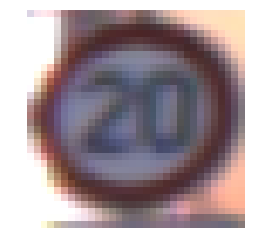

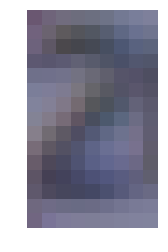

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 4.2187476 -3.6052516]


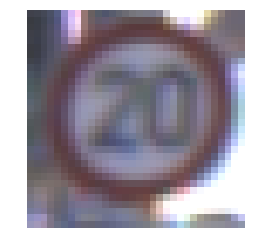

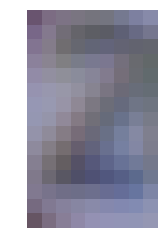

[ 3.4082077 -2.9721549]


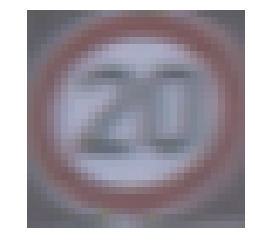

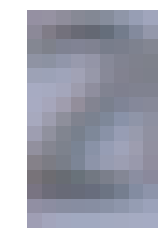

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 0.31259054 -0.19954428]


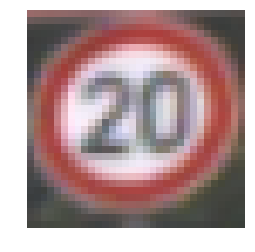

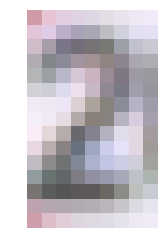

[-2.0893373  1.4216063]


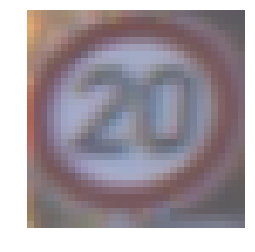

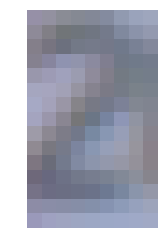

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 0.3187041  -0.49504802]


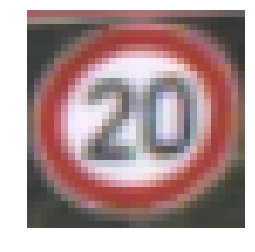

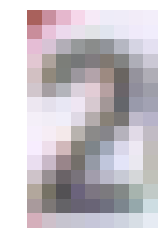

[-2.3422585  1.7066702]


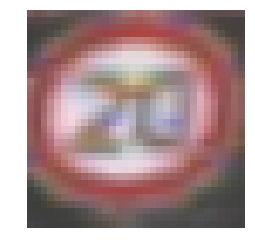

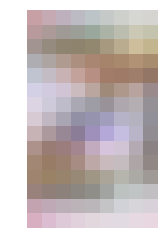

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 1.5711845 -1.2120838]


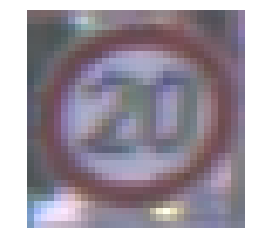

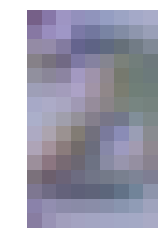

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 0.30409583 -0.528397  ]


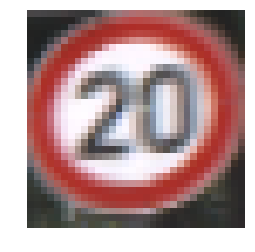

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


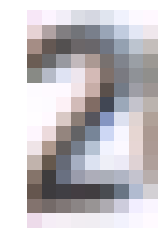

[-3.6319783  2.483928 ]


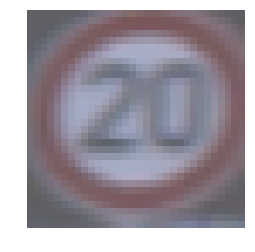

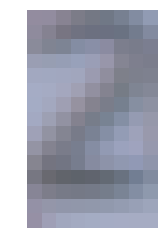

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 0.55494875 -0.07322871]


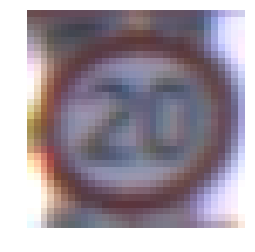

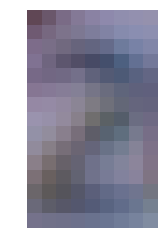

[ 1.2855923 -1.5107834]


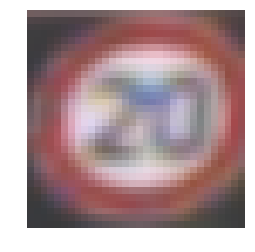

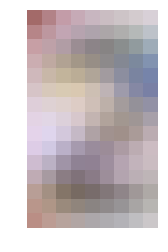

[ 3.5982137 -2.9714603]


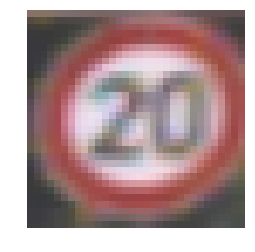

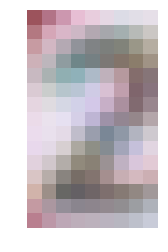

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 2.8051612 -2.4569983]


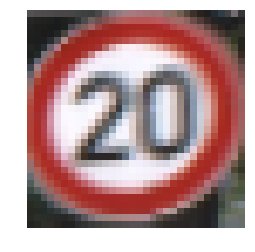

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


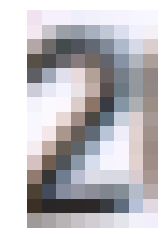

[-4.19695    2.7100148]


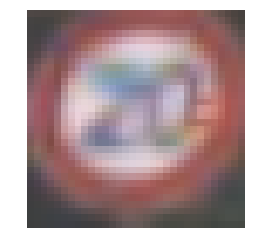

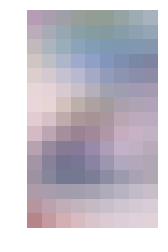

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 4.018643  -4.0232034]


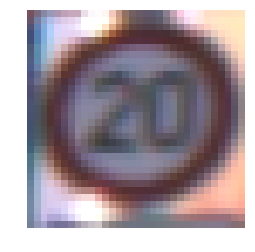

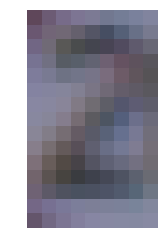

[ 3.287548  -2.9504352]


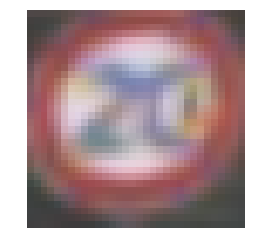

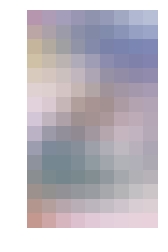

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 3.6193557 -3.6454282]


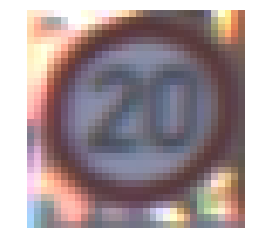

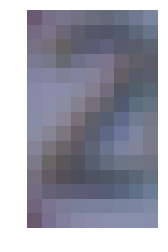

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 3.6652899 -3.004532 ]


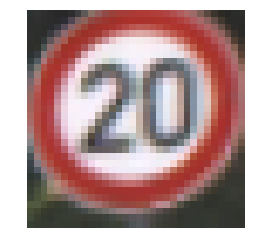

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


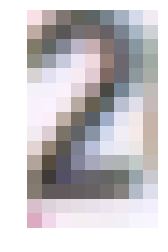

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-2.153166   1.4842534]


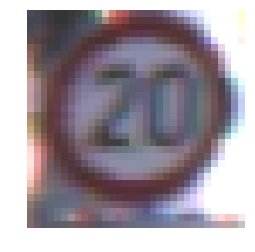

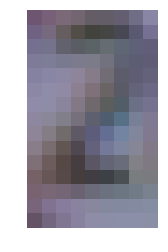

[ 1.5814235  -0.82909507]


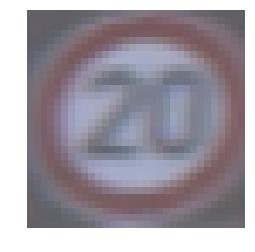

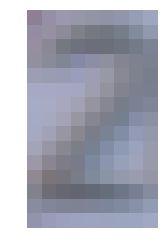

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 1.4605834 -1.3485734]


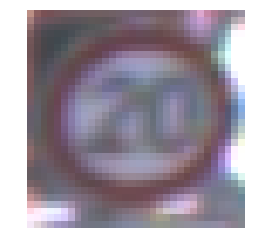

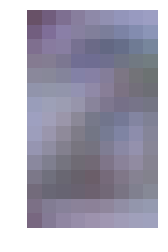

[ 1.4227711 -1.2459943]


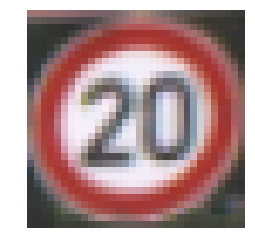

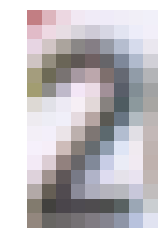

[-2.9699996  1.4177778]


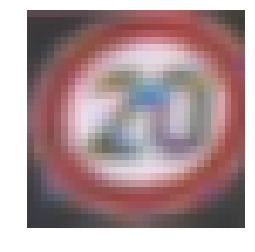

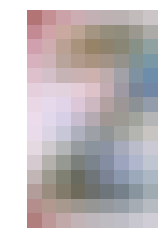

[ 3.11987   -2.6279066]


In [48]:
for x in X_test[np.where(y_test == 0)]:
#for x in X_train[np.where(y_train == 0)][:40]:
    
    x_stn = get_stn_output([x[np.newaxis, :], 0])[0][0]
    x_stn -= np.mean(x_stn)
#     x_p = get_patch(x_stn[np.newaxis, :], pos_2)[0]
    y = model_2.predict(x_stn[np.newaxis, :])[0]
    #if np.argmax(y) == 0:
    plt.imshow(x_stn*.5 + .5)
    plt.axis("off")
    plt.show()

    patch = get_patch(x_stn[np.newaxis, :], pos_2)[0]
    plt.imshow(patch*.5 + .5)
    plt.axis("off")
    plt.show()

    print(y)
    #print(1 / (1 + np.exp(-y)))

In [37]:
np.mean(X_train, axis=(1,2,3), keepdims=True).shape

(34799, 1, 1, 1)

In [80]:
pos = pos_S
y = 14

X_train_d = get_stn_output([X_train, 0])[0]
X_test_d = get_stn_output([X_test, 0])[0]
X_val_d = get_stn_output([X_val, 0])[0]

X_train_d = get_patch(X_train_d, pos)
X_test_d = get_patch(X_test_d, pos)
X_val_d = get_patch(X_val_d, pos)

# Zero mean for each image
# X_train_d -= np.mean(X_train_d, axis=(1, 2, 3), keepdims=True)
# X_val_d -= np.mean(X_val_d, axis=(1, 2, 3), keepdims=True)

# Get training and test labels
y_train_d = (y_train == y).astype(int)
y_test_d = (y_test == y).astype(int)
y_val_d = (y_val == y).astype(int)
# y_train_d = to_categorical(y_train_d, 2)
# y_val_d = to_categorical(y_val_d, 2)

In [81]:
X_train_2 = X_train_d[np.where(y_train_d == 1)]
X_test_2 = X_test_d[np.where(y_test_d == 1)]
X_val_2 = X_val_d[np.where(y_val_d == 1)]

In [82]:
from sklearn import svm

clf = svm.OneClassSVM(nu=0.001, kernel="rbf", gamma='auto')
clf.fit(X_train_2.reshape(X_train_2.shape[0], -1))

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto', kernel='rbf',
      max_iter=-1, nu=0.001, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [83]:
y_pred = clf.predict(X_train_2.reshape(X_train_2.shape[0], -1))/2 + 0.5
np.sum(y_pred) / len(X_train_2)

0.9942028985507246

In [84]:
y_pred = clf.predict(X_train_d.reshape(X_train_d.shape[0], -1))/2 + 0.5
np.sum(y_pred == y_train_d) / X_train_d.shape[0]

0.4194660766113969

In [85]:
y_pred = clf.predict(X_test_2.reshape(X_test_2.shape[0], -1))/2 + 0.5
np.sum(y_pred) / len(X_test_2)

0.937037037037037

In [86]:
y_pred = clf.predict(X_test_d.reshape(X_test_d.shape[0], -1))/2 + 0.5
np.sum(y_pred == y_test_d) / X_test_d.shape[0]

0.46128266033254156

In [87]:
y_pred = clf.predict(X_val_2.reshape(X_val_2.shape[0], -1))/2 + 0.5
np.sum(y_pred) / len(X_val_2)

0.9777777777777777